![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

# Wet Bulb Globe Temperature (WBGT) - Heat stress analyses using Climate DT modeled data 2020-2040

Authors: Dr. Alen Berta (CGI), Cesare Rossi (CGI)

Licence: MIT

Reference:
https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide

Notes:
This example is intended for hands-on learning and does not constitute a comprehensive climatic study. This notebook will showcase the time series point analyses for 2 cities in Croatia (Zagreb as representative of continental climate and Dubrovnik as representative of Mediterranean climate). Service for analysing larger areas and exporting corresponding results in raster files will soon be available on Insula platform.


While other heat stress indices are using temperature and humidity or dew point, WBGT additionaly uses atmoshperic pressure.

Classes are as follows:

- Low risk of heat related illnesses (from 27.7 to 30.5)
- Moderate risk of heat related illnesses (up to value 32.2)
- High risk of heat related illnesses (up to value 33.3)
- Extreme conditions (no outdoor training) (above value 33.3)

You can find more info here:
https://www.weather.gov/arx/wbgt

The data used here are based on SSP3 NEMO model, representing next to worst scenario modeled in Shared Socio-Economic Pathways (SSPs) predicting the highest population development and lowest GDP amongst the considered scenarios in the near future, with global mean temperature rising between 3.85 and 4.55 C until 2100. (more info and photo credit https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change/)
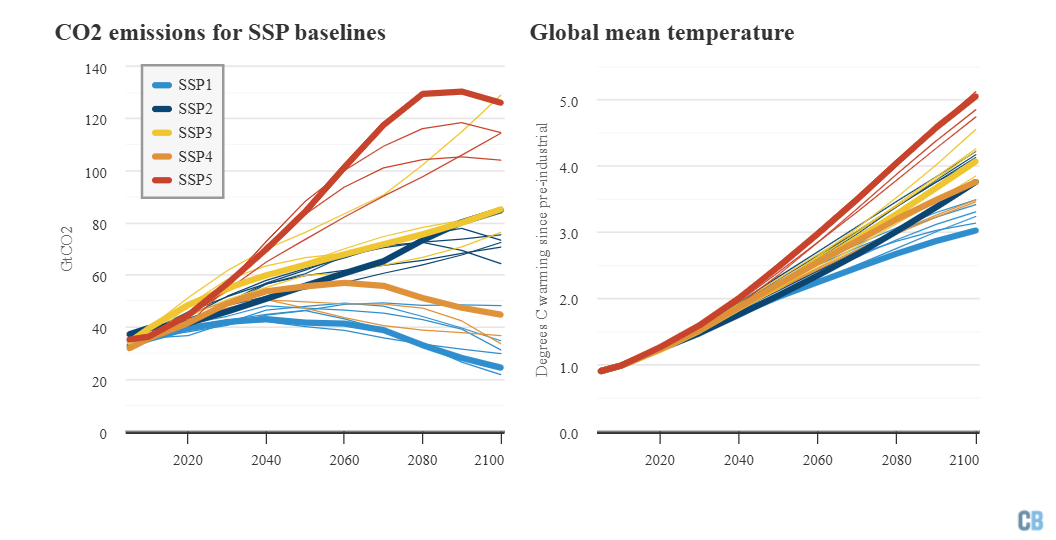

This notebook will provide the analyses relevant for detecting increased temperature stress due to climate change. The data used stem from Climate DT (https://destine.ecmwf.int/news/climate-change-adaptation-digital-twin-a-window-to-the-future-of-our-planet/) and will provide the calculation of some climate extreme indices (https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide).

Specifically we will present the approach to:
 1) Calculate and count the days of increased heat stress per month based on WBGT index
 2) Visualize the same index/indicator on monthly level for selected year with the average and standard deviation values of 2020-2040 (extracted from the Climate DT)

The equations to calculate heat stress indicators are adapted from https://github.com/schwings-clemens/CDS_heat_stress_indicators.

## Data access

In [ ]:
%%capture cap
%run ./cacheb-authentication.py

In [2]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

### Data loading

In [3]:
import xarray as xr
from utils import wbgt
import pandas as pd
import os

In [4]:
data = xr.open_dataset(
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    storage_options={"client_kwargs":{"trust_env":"true"}},
    chunks={},
    engine="zarr",
)

In [5]:
data

<xarray.Dataset> Size: 800TB
Dimensions:           (time: 175320, latitude: 4096, longitude: 8193)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.96 90.0
  * longitude         (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:...
Data variables: (12/34)
    blh               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    chnk              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    d2m               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    e                 (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ewss              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    hcc               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ...                ...
    tp                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate            (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tsr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ttr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Load 2m temperature, dew temperature and presure values.

In [6]:
t2m = data.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"

d2m = data.d2m.astype("float32") - 273.15
d2m.attrs["units"] = "C"

sp=data.sp.astype("float32")

Lat/Lon for point time series and prepare the input data for calculation.

In [7]:
zagreb_lat_lon=(45.8150,15.9819)
dubrovnik_lat_lon=(43.5147,16.4435)

In [8]:
year_of_interest = "2035"

Decide whether you would like to perform a full analysis between 2020 and 2040.

In [9]:
full_2020_2040_analysis = False # If True, the analysis is performed against the whole period, then comparing it to the year_of_interest

<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning:</strong> The computation time for one city/pixel/point for 2020-2040 might require 1.5 hours or more. Therefore, <b>for initial experiments, we suggest keeping the variable full_2020_2040_analysis set to False.</b>
</div>

In [10]:
# Select the data for Zagreb
t2m_zagreb = t2m.sel(latitude=zagreb_lat_lon[0], longitude=zagreb_lat_lon[1], method='nearest')
d2m_zagreb = d2m.sel(latitude=zagreb_lat_lon[0], longitude=zagreb_lat_lon[1], method='nearest')
sp_zagreb= sp.sel(latitude=zagreb_lat_lon[0], longitude=zagreb_lat_lon[1], method='nearest')

# Select the data for dubrovnik
t2m_dubrovnik = t2m.sel(latitude=dubrovnik_lat_lon[0], longitude=dubrovnik_lat_lon[1], method='nearest')
d2m_dubrovnik = d2m.sel(latitude=dubrovnik_lat_lon[0], longitude=dubrovnik_lat_lon[1], method='nearest')
sp_dubrovnik = sp.sel(latitude=dubrovnik_lat_lon[0], longitude=dubrovnik_lat_lon[1], method='nearest')

if not full_2020_2040_analysis:
    # Subset the data for a given year
    t2m_zagreb = t2m_zagreb.sel(time=year_of_interest)
    d2m_zagreb = d2m_zagreb.sel(time=year_of_interest)
    sp_zagreb = sp_zagreb.sel(time=year_of_interest)

    t2m_dubrovnik = t2m_dubrovnik.sel(time=year_of_interest)
    d2m_dubrovnik = d2m_dubrovnik.sel(time=year_of_interest)
    sp_dubrovnik = sp_dubrovnik.sel(time=year_of_interest)

In [11]:
# Convert the temperature from C to F
t2m_zagreb_f = 9/5 * t2m_zagreb + 32
t2m_dubrovnik_f = 9/5 * t2m_dubrovnik + 32

# Convert the temperature from C to K
t2m_zagreb_K = t2m_zagreb + 273.15
t2m_dubrovnik_K = t2m_dubrovnik + 273.15

In [12]:
# Calculate relative humidity for Zagreb and dubrovnik
RH_zagreb = wbgt.calculate_relative_humidity(t2m_zagreb, d2m_zagreb)
RH_dubrovnik = wbgt.calculate_relative_humidity(t2m_dubrovnik, d2m_dubrovnik)

In [13]:
print(t2m_dubrovnik, d2m_dubrovnik,sp_dubrovnik)

<xarray.DataArray 't2m' (time: 8760)> Size: 35kB
dask.array<getitem, shape=(8760,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
    entireAtmosphere  float64 8B ...
    latitude          float64 8B 43.49
    longitude         float64 8B 16.44
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 70kB 2035-01-01 ... 2035-12-31T23...
Attributes:
    units:    C <xarray.DataArray 'd2m' (time: 8760)> Size: 35kB
dask.array<getitem, shape=(8760,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
    entireAtmosphere  float64 8B ...
    latitude          float64 8B 43.49
    longitude         float64 8B 16.44
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 70kB 2035-01-01 ... 2035-12-31T23...
Attributes:
    units:    C <xarray.DataArray 'sp' (time: 8760)> Size: 35kB
dask.array<getitem, shape=(8760,

### WBGT calculation

The following cells will:

1) Calculate WGBT based on temperature, humidity and atmoshperic pressure on preselected datasets (in this case Zagreb and Dubrovnik between 2020 and 2040),
2) Detect the maximum value of index within the day
3) Categorize this value into WBGT categories
4) Count unique categories per month
5) extract the values for one selected year (2035),
6) calculate the mean and standard deviation for each month between 2020-2040,
7) plot on one plot per WBGT category the average from 2020-2040 as point, st.dev from 2020-2040 as lines and the values for selected year/month as bars 


In [14]:
# Calculate WBGT for Zagreb and Dubrovnik
WBGT_zagreb = wbgt.WBGT(t2m_zagreb_K, RH_zagreb, sp_zagreb)
WBGT_dubrovnik = wbgt.WBGT(t2m_dubrovnik_K, RH_dubrovnik, sp_dubrovnik)

In [15]:
# Assign a name to the DataArray
WBGT_zagreb.name = "WBGT"
WBGT_dubrovnik.name = "WBGT"

<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning:</strong>The following cell usually takes <b>5 minutes</b> for each city/pixel/point. <b>If the variable full_2020_2040_analysis is set to True it might require 1.5 hour or more for one city/pixel/point.</b>
</div>

In [16]:
# Convert to DataFrame and resample to daily maximum
%time WBGT_zagreb_daily_max = WBGT_zagreb.resample(time='D').max().to_dataframe().reset_index()
%time WBGT_dubrovnik_daily_max = WBGT_dubrovnik.resample(time='D').max().to_dataframe().reset_index()

CPU times: user 1min 14s, sys: 27.8 s, total: 1min 42s
Wall time: 3min 34s
CPU times: user 54.1 s, sys: 29.1 s, total: 1min 23s
Wall time: 2min 52s


In [17]:
# Apply categorization
WBGT_zagreb_daily_max['Category'] = WBGT_zagreb_daily_max['WBGT'].apply(wbgt.categorize_WBGT)
WBGT_dubrovnik_daily_max['Category'] = WBGT_dubrovnik_daily_max['WBGT'].apply(wbgt.categorize_WBGT)

In [18]:
# Count the number of days within each month per category
WBGT_zagreb_monthly_counts = WBGT_zagreb_daily_max.groupby([WBGT_zagreb_daily_max['time'].dt.to_period('M'),'Category']).size().unstack(fill_value=0)
WBGT_dubrovnik_monthly_counts = WBGT_dubrovnik_daily_max.groupby([WBGT_dubrovnik_daily_max['time'].dt.to_period('M'),'Category']).size().unstack(fill_value=0)

In [19]:
# Save the results - this is useful later in case you would like to skip to the computation step above and play with the data
csv_directory = "csv"
if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)

output_file = f'{csv_directory}/WBGT_monthly_zagreb.csv'
WBGT_zagreb_monthly_counts.to_csv(output_file, index=True)

output_file = f'{csv_directory}/WBGT_monthly_dubrovnik.csv'
WBGT_dubrovnik_monthly_counts.to_csv(output_file, index=True)

In [20]:
# Read the data from CSV files
WBGT_zagreb_monthly_counts = pd.read_csv(f'{csv_directory}/WBGT_monthly_zagreb.csv', index_col=0, parse_dates=True)
WBGT_dubrovnik_monthly_counts = pd.read_csv(f'{csv_directory}/WBGT_monthly_dubrovnik.csv', index_col=0, parse_dates=True)

<div style="border: 2px solid #28a745; background-color: #d4edda; padding: 10px; border-radius: 5px;">
  <strong>💡 Tip:</strong> In the graphs below, the average and standard deviation value for the period 2020-2040 are meaningful <b>only if the variable full_2020_2040_analysis was True</b>.</a>
</div>

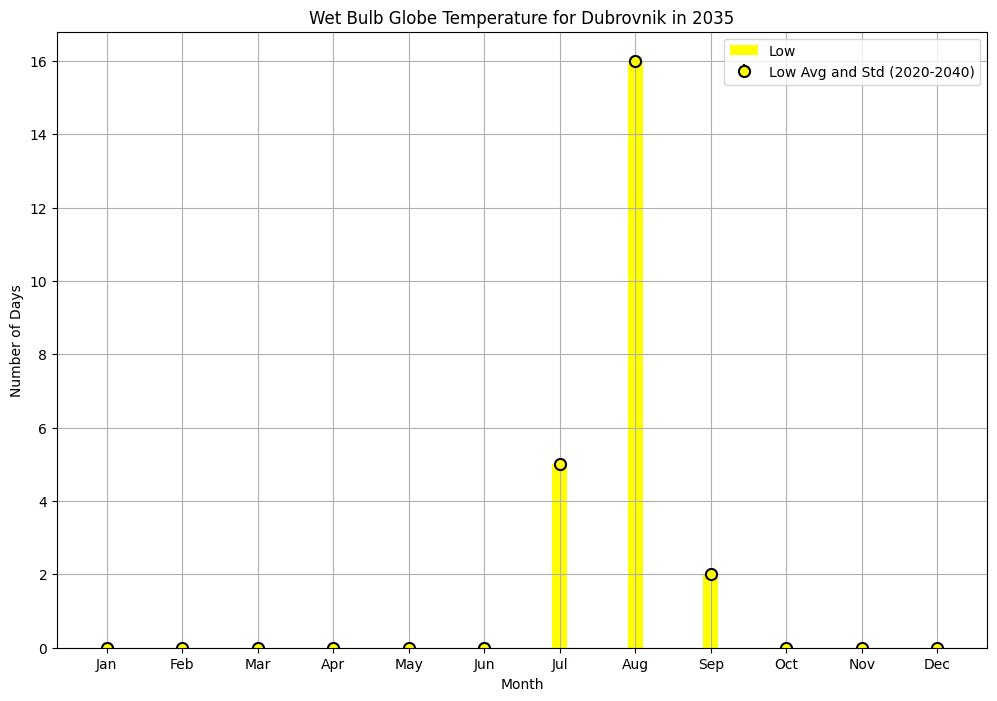

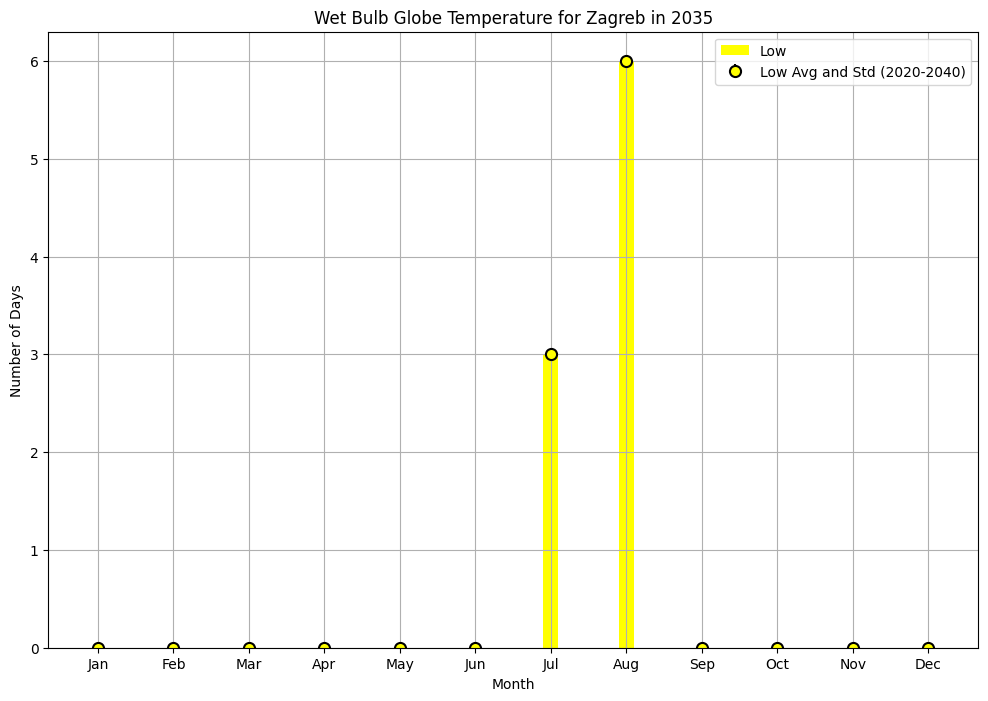

In [21]:
# Calculate the average and standard deviation per month for each category for the whole data range
WBGT_zagreb_monthly_stats = WBGT_zagreb_monthly_counts.groupby(WBGT_zagreb_monthly_counts.index.month).agg(['mean', 'std'])
WBGT_dubrovnik_monthly_stats = WBGT_dubrovnik_monthly_counts.groupby(WBGT_dubrovnik_monthly_counts.index.month).agg(['mean', 'std'])

# Select the data for 2035
WBGT_zagreb_yoi = WBGT_zagreb_monthly_counts.loc[str(year_of_interest)]
WBGT_dubrovnik_yoi = WBGT_dubrovnik_monthly_counts.loc[str(year_of_interest)]

# Plot for Dubrovnik
wbgt.plot_heat_index_categories(WBGT_dubrovnik_yoi, WBGT_dubrovnik_monthly_stats, "Dubrovnik", year_of_interest)

# Plot for Zagreb
wbgt.plot_heat_index_categories(WBGT_zagreb_yoi, WBGT_zagreb_monthly_stats, "Zagreb", year_of_interest)

<div style="border: 2px solid #909090; background-color: #e1e1e1; padding: 10px; border-radius: 5px;">

As a reference, the following graphs present the results of the full computation (i.e., <i>full_2020_2040_analysis = True</i>), comparing the year 2035 with the entire 2020–2040 range.

<table>
<tr>
    <th><img src="images/wetbulb_output_0.png" width="600"></th>
    <th><img src="images/wetbulb_output_1.png" width="600"></th>
</table>
</div>